In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au


In [3]:

trial_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'
trial_df = pd.read_csv(trial_file)

In [111]:
# Explore new custom dataframe

bonsai_df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/new_bonsai_df_cleaned.csv')

bonsai_df = bu.add_session_column(bonsai_df)

In [112]:
# Old dataframe for refrence

old_bonsai_df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')

old_bonsai_df = bu.add_session_column(old_bonsai_df)


In [113]:
print(f'Old Bonsai DF: {old_bonsai_df.describe()}')
print(f'Bonsai DF: {bonsai_df.describe()}')

Old Bonsai DF:           subject_id                   session_date     nwb_suffix  \
count    9083.000000                           9083    9083.000000   
mean   666054.030607  2023-07-03 13:44:52.370362368  125173.746670   
min    447921.000000            2019-06-25 00:00:00       0.000000   
25%    643252.000000            2022-12-14 00:00:00   95249.000000   
50%    689799.000000            2023-12-07 00:00:00  122837.000000   
75%    717617.000000            2024-07-10 00:00:00  153619.500000   
max    769888.000000            2024-11-06 00:00:00  235757.000000   
std     82752.682467                            NaN   40012.908468   

           session  session_run_time_in_min  water_in_session_foraging  \
count  9083.000000              9072.000000                4956.000000   
mean     17.086425                78.259025                   0.499840   
min       1.000000                 7.000000                   0.000000   
25%       7.000000                65.285493               

In [152]:
bonsai_df['curriculum_version'].unique()

array([nan, '1.0', '0.1', '2.1', '2.2', '2.3', '2.2.1rwdDelay159',
       '2.3.1rwdDelay159', '2.0', '2.1rwdDelay159', '2.2rwdDelay159',
       '2.3rwdDelay159'], dtype=object)

In [115]:
bonsai_df.columns.to_list()

['subject_id',
 'session_date',
 'nwb_suffix',
 'rig',
 'user_name',
 'experiment_description',
 'task',
 'notes',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'water_in_session_foraging',
 'water_in_session_manual',
 'water_in_session_total',
 'water_after_session',
 'water_day_total',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'weight_after_ratio',
 'p_reward_sum_mean',
 'p_reward_sum_std',
 'p_reward_sum_median',
 'p_reward_contrast_mean',
 'p_reware_contrast_median',
 'effective_block_length_mean',
 'effective_block_length_std',
 'effective_block_length_median',
 'effective_block_length_min',
 'effective_block_length_max',
 'duration_gocue_stop_mean',
 'duration_gocue_stop_std',
 'duration_gocue_stop_median',
 'duration_gocue_stop_min',
 'duration_gocue_stop_max',
 'du

In [116]:
# Filtering

bonsai_df = bonsai_df.loc[:, ['subject_id', 'session_date', 
                                     'new_session', 'curriculum_name', 'curriculum_version', 
                                     'current_stage_actual', 'task', 'p_reward_sum_mean', 
                                     'effective_block_length_mean','autowater_collected', 'autowater_ignored',
                                     'ignore_rate', 'reward_rate', 'finished_rate', 'double_dipping_rate_finished_trials',
                                     'double_dipping_rate_finished_reward_trials',
                                     'double_dipping_rate_finished_noreward_trials',
                                     'lick_consistency_mean_finished_trials',
                                     'lick_consistency_mean_finished_reward_trials',
                                     'lick_consistency_mean_finished_noreward_trials',
                                     'foraging_performance', 'foraging_eff', 'foraging_eff_random_seed',
                                     'foraging_choice', 'foraging_choice_global','early_lick_rate', 
                                     'invalid_lick_ratio', 'double_dipping_rate_finished_trials', 
                                     'lick_consistency_mean_finished_trials','reaction_time_mean']]

bonsai_df.columns.to_list()


['subject_id',
 'session_date',
 'new_session',
 'curriculum_name',
 'curriculum_version',
 'current_stage_actual',
 'task',
 'p_reward_sum_mean',
 'effective_block_length_mean',
 'autowater_collected',
 'autowater_ignored',
 'ignore_rate',
 'reward_rate',
 'finished_rate',
 'double_dipping_rate_finished_trials',
 'double_dipping_rate_finished_reward_trials',
 'double_dipping_rate_finished_noreward_trials',
 'lick_consistency_mean_finished_trials',
 'lick_consistency_mean_finished_reward_trials',
 'lick_consistency_mean_finished_noreward_trials',
 'foraging_performance',
 'foraging_eff',
 'foraging_eff_random_seed',
 'foraging_choice',
 'foraging_choice_global',
 'early_lick_rate',
 'invalid_lick_ratio',
 'double_dipping_rate_finished_trials',
 'lick_consistency_mean_finished_trials',
 'reaction_time_mean']

##### Explore feature distributions and variability

In [117]:
# Feature notes

# finished rate -- upwards increase at stage level, plateu at session 20
# ignore rate -- downwards decrease at stage level, plateu at session 20
# reward rate -- V shape (STAGE_3) at stage level, sig. decrease until session 10 then slow decrease
# median reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7
# mean reaction time -- normal (but only until STAGE_FINAL) decrease at stage level, ONLY until session ~7
# early lick rate -- upwards V shape (STAGE_3) at stage level, plateu at session 20
# invalid lick ratio -- slight increase at stage level (but only until STAGE_FINAL), ONLY until session ~7
# double dipping rate (finished trials) -- large decrease at until STAGE_2, then flat,  plateu at session 20
# double dipping rate rewarded (finished trials) -- decrease at stage level,  plateu at session 10
# double dipping rate non-rewarded (finished trials) -- decrease at stage level but only until STAGE_2,  plateu at session 10
# lick consistency mean (finished trials) -- increase at stage level, plateu at session 20
# lick consistency mean (finished reward trials) -- increase at stage level, plateu at session 10
# lick consistency mean (finished non-rewarded trials) -- increase until STAGE 3, then slight decrease, plateu at session 10

In [118]:
# Define stage order

stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
bonsai_df['current_stage_actual'] = pd.Categorical(bonsai_df['current_stage_actual'], categories=stage_order)


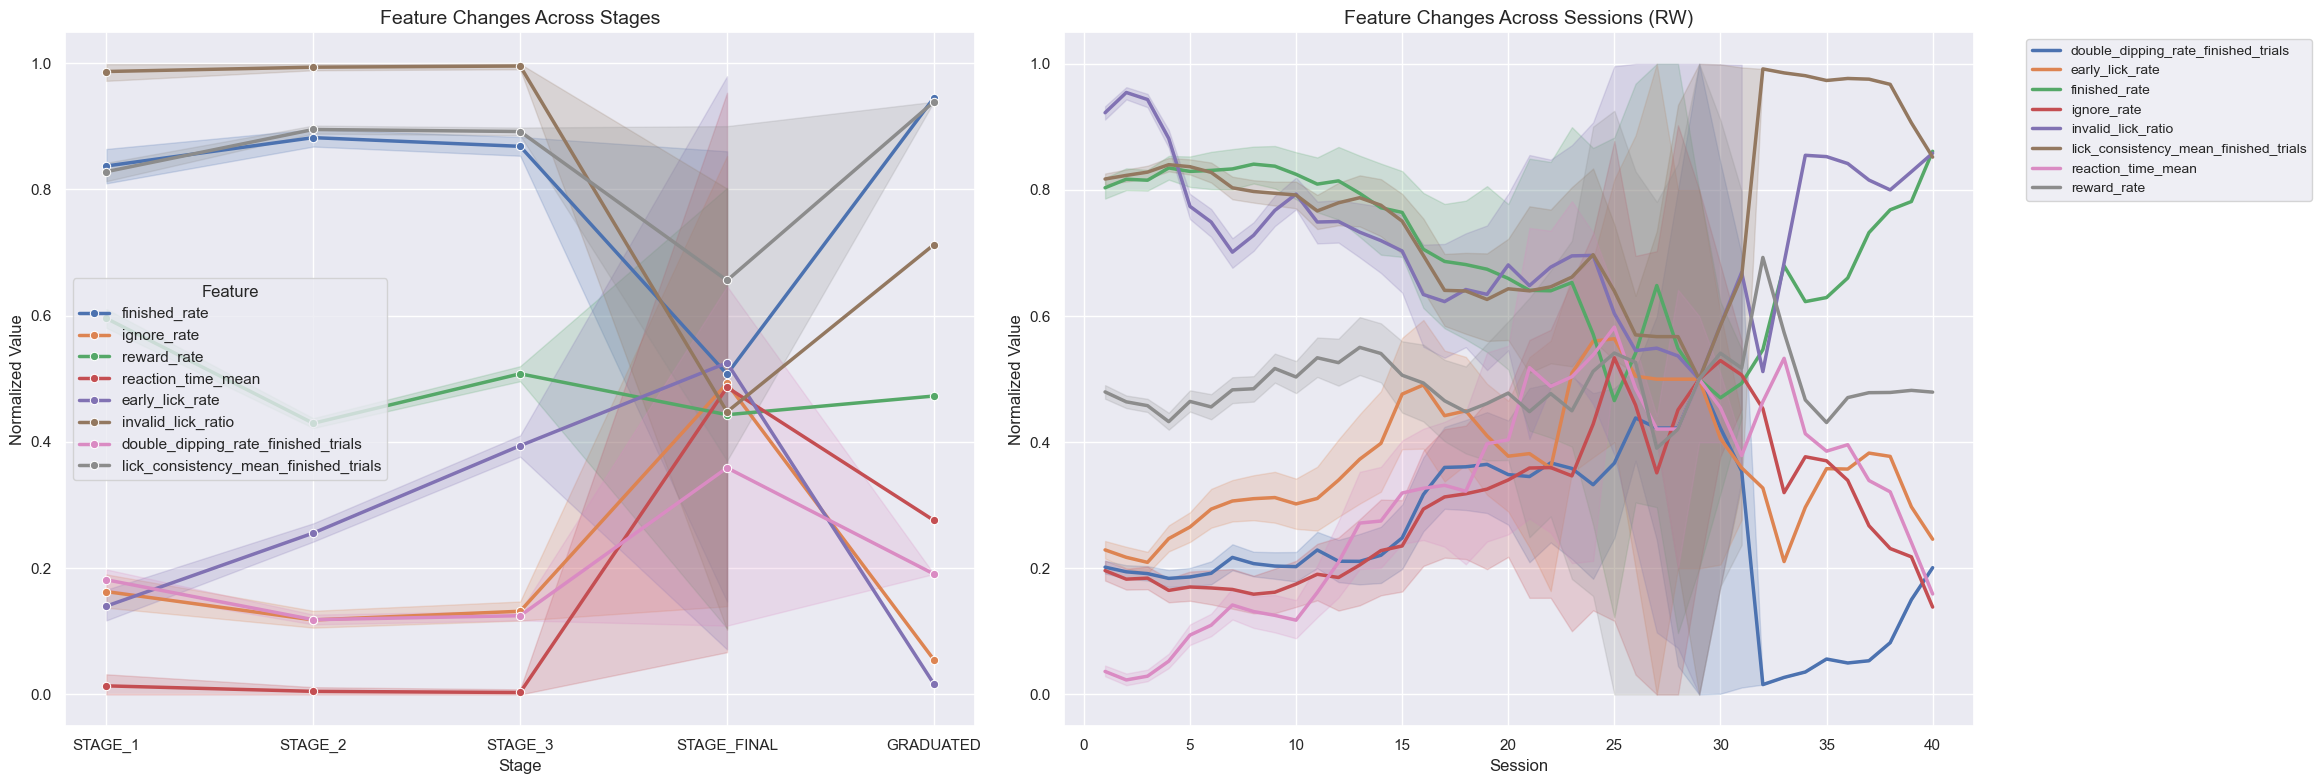

In [119]:
# Create normalized versions of each feature by stage
normalized_df = bonsai_df.copy()

features = [
    'finished_rate', 
    'ignore_rate', 
    'reward_rate', 
    'reaction_time_mean', 
    'early_lick_rate',
    'invalid_lick_ratio', 
    'double_dipping_rate_finished_trials',
    'lick_consistency_mean_finished_trials'
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

normalized_stage_df = bonsai_df.copy()
for feature in features:
    normalized_stage_df[feature] = normalized_stage_df.groupby('current_stage_actual')[feature].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    )

melted_stage_df = normalized_stage_df.melt(
    id_vars=['current_stage_actual'],
    value_vars=features,
    var_name='Feature',
    value_name='Normalized Value'
)

sns.lineplot(
    data=melted_stage_df,
    x='current_stage_actual',
    y='Normalized Value',
    hue='Feature',
    linewidth=2.5,
    marker='o',
    ax=ax1
)
ax1.set_title('Feature Changes Across Stages', fontsize=14)
ax1.set_xlabel('Stage', fontsize=12)
ax1.set_ylabel('Normalized Value', fontsize=12)

normalized_session_df = bonsai_df.copy()
for feature in features:
    normalized_session_df[feature] = normalized_session_df.groupby('new_session')[feature].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x
    )

melted_session_df = normalized_session_df.melt(
    id_vars=['new_session'],
    value_vars=features,
    var_name='Feature',
    value_name='Normalized Value'
)

# Apply rolling average
window_size = 5
melted_session_smooth = melted_session_df.groupby('Feature').rolling(
    window=window_size,
    center=True,
    min_periods=1,
    on='new_session'
)['Normalized Value'].mean().reset_index()

sns.lineplot(
    data=melted_session_smooth,
    x='new_session',
    y='Normalized Value',
    hue='Feature',
    linewidth=2.5,
    ax=ax2
)
ax2.set_title('Feature Changes Across Sessions (RW)', fontsize=14)
ax2.set_xlabel('Session', fontsize=12)
ax2.set_ylabel('Normalized Value', fontsize=12)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

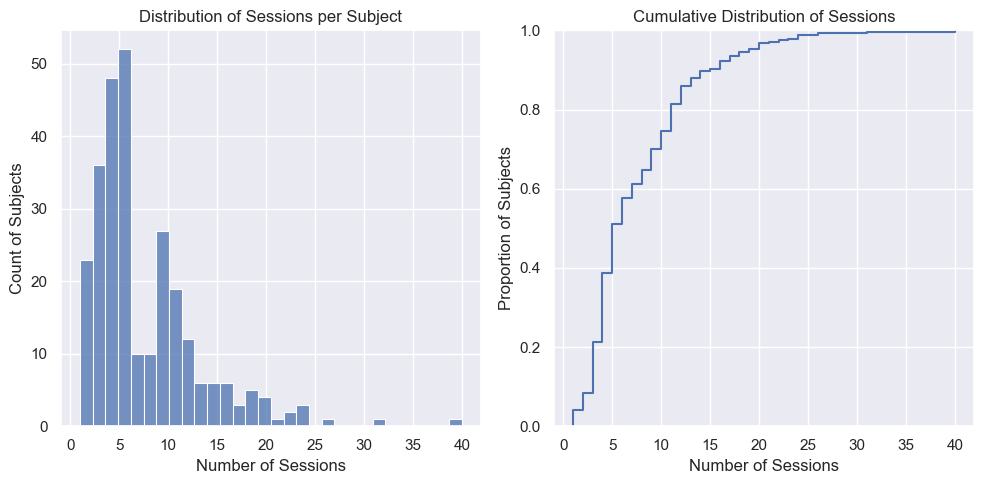

Threshold  1 sessions: 276 subjects (100.0%)
Threshold  5 sessions: 169 subjects ( 61.2%)
Threshold 10 sessions:  83 subjects ( 30.1%)
Threshold 15 sessions:  28 subjects ( 10.1%)
Threshold 20 sessions:  13 subjects (  4.7%)
Threshold 25 sessions:   3 subjects (  1.1%)
Threshold 30 sessions:   2 subjects (  0.7%)


In [120]:
# Calculate sessions per subject
sessions_per_subject = bonsai_df.groupby('subject_id').size().reset_index()
sessions_per_subject.columns = ['subject_id', 'session_count']

# Create figure with multiple plots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))

# 1. Histogram
sns.histplot(
    data=sessions_per_subject,
    x='session_count',
    bins=30,
    ax=ax1
)
ax1.set_title('Distribution of Sessions per Subject')
ax1.set_xlabel('Number of Sessions')
ax1.set_ylabel('Count of Subjects')

# 3. Cumulative distribution
sns.ecdfplot(
    data=sessions_per_subject,
    x='session_count',
    ax=ax2
)
ax2.set_title('Cumulative Distribution of Sessions')
ax2.set_xlabel('Number of Sessions')
ax2.set_ylabel('Proportion of Subjects')

plt.tight_layout()
plt.show()

# Print percentage of subjects that would be included at different thresholds
thresholds = [1, 5, 10, 15, 20, 25, 30]
for threshold in thresholds:
    n_subjects = len(sessions_per_subject[sessions_per_subject['session_count'] >= threshold])
    percentage = (n_subjects / len(sessions_per_subject)) * 100
    print(f"Threshold {threshold:2d} sessions: {n_subjects:3d} subjects ({percentage:5.1f}%)")

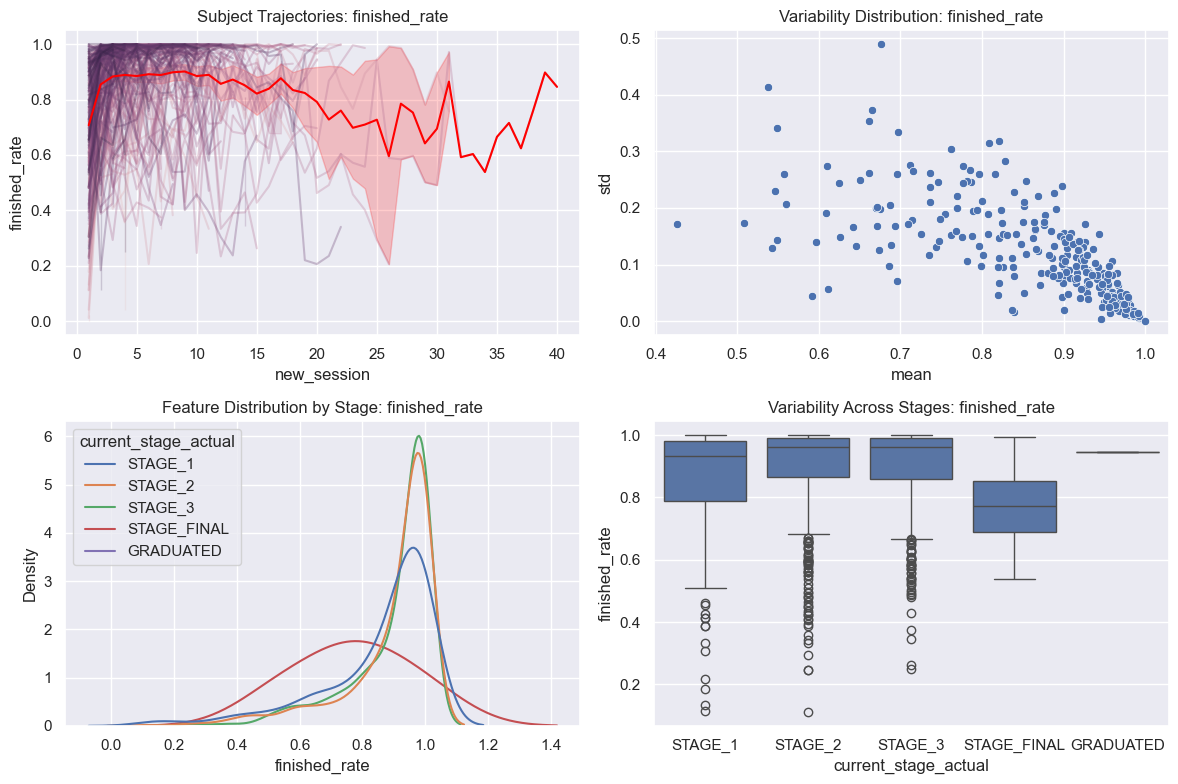

In [121]:
# Use finished_rate as example for feature selection
feature = 'finished_rate'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Subject trajectories 
sns.lineplot(
    data=bonsai_df,
    x='new_session',
    y=feature,
    hue='subject_id',
    alpha=0.3,
    legend=False,
    ax=ax1
)

sns.lineplot(
    data=bonsai_df,
    x='new_session',
    y=feature,
    color='red',
    ax=ax1
)

ax1.set_title(f'Subject Trajectories: {feature}')

# Feature variation between subjects
subject_var = bonsai_df.groupby('subject_id')[feature].agg(['mean', 'std']).reset_index()

sns.scatterplot(
    data=subject_var,
    x='mean',
    y='std',
    ax=ax2
)
ax2.set_title(f'Variability Distribution: {feature}')
ax2.set_xlabel('mean')
ax2.set_ylabel('std')

# KDE of feature distribution
sns.kdeplot(
    data=bonsai_df,
    x=feature,
    hue='current_stage_actual',
    common_norm=False,
    ax=ax3
)
ax3.set_title(f'Feature Distribution by Stage: {feature}')

# Variability across stages
sns.boxplot(
    data=bonsai_df,
    x='current_stage_actual',
    y=feature,
    ax=ax4
)
ax4.set_title(f'Variability Across Stages: {feature}')

plt.tight_layout()
plt.show()


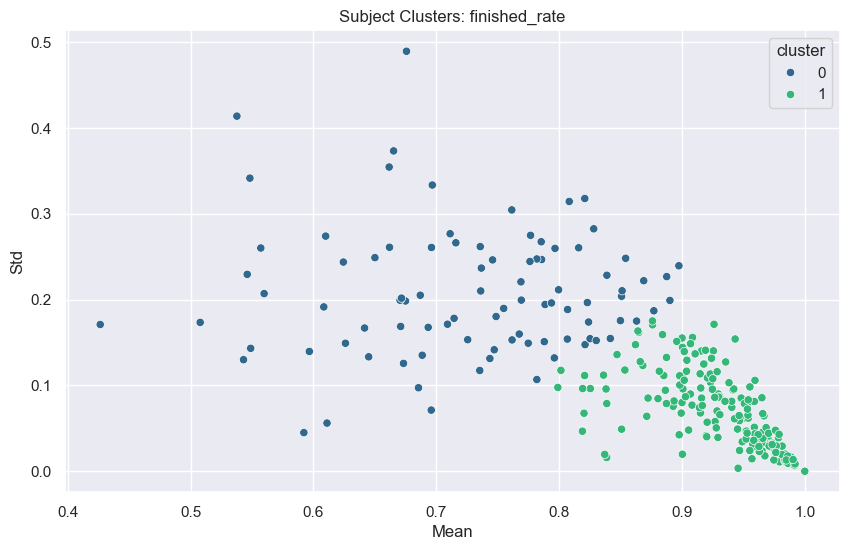

In [122]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Preprocess
subject_var = bonsai_df.groupby('subject_id')[feature].agg(['mean', 'std']).reset_index()

subject_var = subject_var.dropna()

# Prepare data
subject_features = subject_var[['mean', 'std']].values

# Standardize features
scaler = StandardScaler()
subject_features_scaled = scaler.fit_transform(subject_features)

n_clusters = 2 # Two groups of learners? 

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
subject_var['cluster'] = kmeans.fit_predict(subject_features_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=subject_var,
    x='mean',
    y='std',
    hue='cluster',
    palette='viridis'
)
plt.title(f'Subject Clusters: {feature}')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()


In [123]:
from scipy import stats
from sklearn.metrics import silhouette_score

def extract_temporal_features(df, feature_col, subject_col='subject_id', time_col='new_session'):
    """
    Extract temporal dynamics of a feature across subjects

    Args: 
    df: pd.DataFrame - Input DataFrame
    feature_col: str - Name of feature to extract temporal dynamics from
    subject_col: str - Name of subject column
    time_col: str - Name of time column

    Returns: 
    pd.DataFrame: DataFrame with temporal dynamics of the feature
    """

    features = []

    for subject in df[subject_col].unique():
        subject_data = df[df[subject_col] == subject].sort_values(time_col)
        y = subject_data[feature_col].values

        if np.all(np.isnan(y)):
            print(f"Skipping subject {subject} due to all NaN values")
            continue

        valid_idx = ~np.isnan(y)
        y = y[valid_idx]

        if len(y) < 2:
            print(f"Skipping subject {subject} due to insufficient data")
            continue

        x = np.arange(len(y))


        # Linear regression features
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Non linear features
        first_half_mean = np.mean(y[:len(y)//2])
        second_half_mean = np.mean(y[len(y)//2:])
        
        # volatility calculation
        volatility = np.std(np.diff(y))

        # Find percentage of increase and decrease
        diffs = np.diff(y)
        pct_increase = np.sum(diffs > 0) / len(diffs)

        features.append({
            'subject_id': subject,
            'slope': slope,
            'r_squared': r_value**2,
            'mean_change': second_half_mean - first_half_mean,
            'volatility': volatility,
            'pct_increase': pct_increase
        })

    return pd.DataFrame(features)

In [124]:
temporal_features = extract_temporal_features(bonsai_df, feature_col='finished_rate')

temporal_features.head()

Skipping subject 671087 due to insufficient data
Skipping subject 680600 due to insufficient data
Skipping subject 684874 due to insufficient data
Skipping subject 706893 due to insufficient data
Skipping subject 711254 due to insufficient data
Skipping subject 711256 due to insufficient data
Skipping subject 713378 due to insufficient data
Skipping subject 713379 due to insufficient data
Skipping subject 715083 due to insufficient data
Skipping subject 717474 due to insufficient data
Skipping subject 722679 due to insufficient data


,subject_id,slope,r_squared,mean_change,volatility,pct_increase
0,668463,0.127494,1.00000,0.127494,0.000000,1.0
1,668551,0.368159,1.00000,0.368159,0.000000,1.0
2,680398,0.241186,1.00000,0.241186,0.000000,1.0
3,680399,0.028020,1.00000,0.028020,0.000000,1.0
4,680599,0.028157,0.07768,0.026671,0.390947,0.5


In [125]:
def cluster_temporal_patterns(df, n_clusters=2, random_state=42):
    """
    Cluster subjects based on their temporal patterns

    Args:
    df: pd.DataFrame - Input DataFrame
    n_clusters: int - Number of clusters to create
    random_state: int - Random seed for reproducibility

    Returns: 
    tuple: DataFrame with cluster assignments, trained KMeans model
    """
    # Features of clustering
    features = ['slope', 'r_squared','mean_change', 'volatility', 'pct_increase']

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df[features])

    # Cluster subjects
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(features_scaled)

    # Add cluster assignment
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = clusters

    # Get silhouette score
    silhouette_avg = silhouette_score(features_scaled, clusters)
    print(f"Silhouette score: {silhouette_avg:.2f}")

    return df_with_clusters, kmeans

In [126]:
clustered_df, kmeans = cluster_temporal_patterns(temporal_features, n_clusters=2)

clustered_df.head()

Silhouette score: 0.33


,subject_id,slope,r_squared,mean_change,volatility,pct_increase,cluster
0,668463,0.127494,1.00000,0.127494,0.000000,1.0,1
1,668551,0.368159,1.00000,0.368159,0.000000,1.0,1
2,680398,0.241186,1.00000,0.241186,0.000000,1.0,1
3,680399,0.028020,1.00000,0.028020,0.000000,1.0,1
4,680599,0.028157,0.07768,0.026671,0.390947,0.5,0


In [127]:
def plot_cluster_characteristics(df_clustered, feature_col, original_df):
    """
    Plot cluster characteristics including temporal patterns.
    """
    plt.figure(figsize=(15, 5))
    
    # Slope vs Mean Change
    plt.subplot(131)
    sns.scatterplot(data=df_clustered, x='slope', y='mean_change', 
                   hue='cluster', palette='viridis')
    plt.title('Slope vs Mean Change')
    
    # Volatility vs Percentage Increase
    plt.subplot(132)
    sns.scatterplot(data=df_clustered, x='volatility', y='pct_increase', 
                   hue='cluster', palette='viridis')
    plt.title('Volatility vs % Increase')
    
    # Average temporal patterns per cluster
    plt.subplot(133)
    for cluster in sorted(df_clustered['cluster'].unique()):
        cluster_subjects = df_clustered[df_clustered['cluster'] == cluster]['subject_id']
        cluster_data = original_df[original_df['subject_id'].isin(cluster_subjects)]
        
        mean_pattern = cluster_data.groupby('new_session')[feature_col].mean()
        plt.plot(mean_pattern.index, mean_pattern.values, label=f'Cluster {cluster}')
    
    plt.title('Average Temporal Patterns')
    plt.xlabel('Session')
    plt.ylabel(feature_col)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

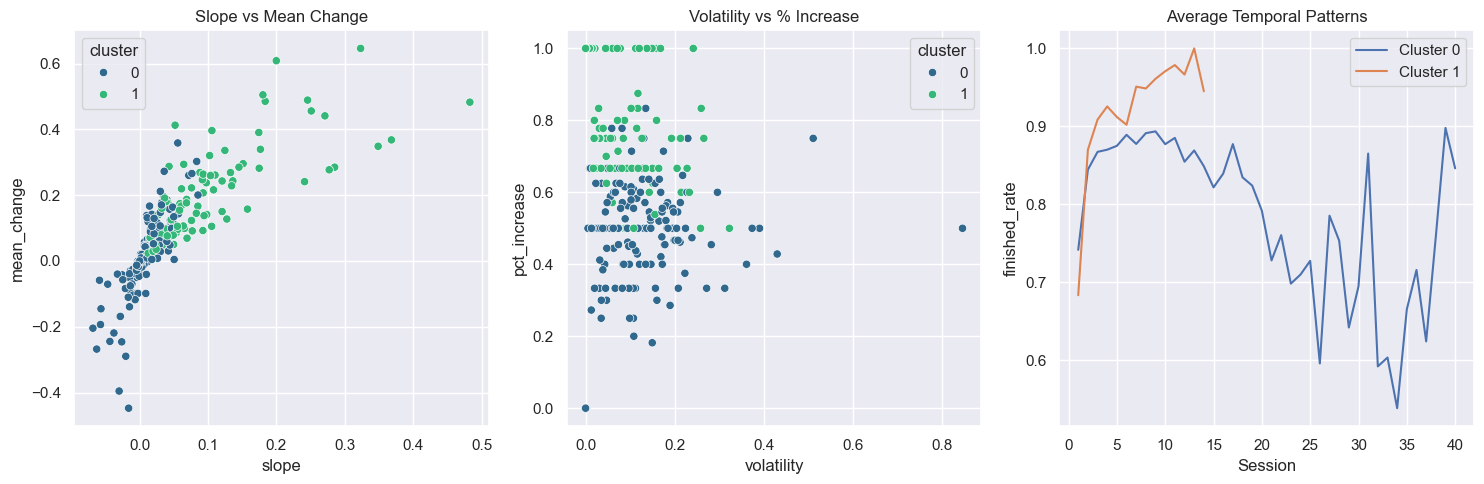

In [128]:
plot_cluster_characteristics(clustered_df, 'finished_rate', bonsai_df)

##### Metric Dev

In [129]:
# Test dev
import itertools

learning_metric = (
    (2 * finished_rate * reward_rate * lick_consistency_mean_finished_trials) /
    (1 + early_lick_rate + 2 * double_dipping_rate_finished_trials + invalid_lick_ratio)
)

# Test weighting
for w1, w2, w3 in itertools.product([1,2,3], repeat=3):
    metric = (
        (w1 * finished_rate * w2 * reward_rate * w3 * lick_consistency_mean_finished_trials) /
        (1 + early_lick_rate + double_dipping_rate_finished_trials + invalid_lick_ratio)
    )

# Check if metric increases across stages
sns.boxplot(data=normalized_df, x='current_stage_actual', y='learning_metric')

NameError: name 'finished_rate' is not defined

In [136]:
bonsai_df['lick_consistency_mean_finished_trials'].describe()

,lick_consistency_mean_finished_trials,lick_consistency_mean_finished_trials
count,2067.000000,2067.000000
mean,0.936161,0.936161
std,0.063966,0.063966
min,0.516033,0.516033
25%,0.913955,0.913955
50%,0.955072,0.955072
75%,0.979308,0.979308
max,1.000000,1.000000


In [137]:
# Protyping metrics
test_session_df = bonsai_df.copy()

# Testing filtering
version = '2.3'
version_filt_test_session_df = test_session_df[test_session_df['curriculum_version'] == version]
curriculum_name = 'Uncoupled Baiting'
curriculum_filt_test_session_df = test_session_df[test_session_df['curriculum_name'] == curriculum_name]

# Reset index and ensure no duplicates
curriculum_filt_test_session_df = curriculum_filt_test_session_df.reset_index(drop=True)

# Convert to numpy arrays and ensure they're 1D
early_lick = curriculum_filt_test_session_df['early_lick_rate'].values.ravel()
double_dip = curriculum_filt_test_session_df['double_dipping_rate_finished_trials'].values.ravel()
finished = curriculum_filt_test_session_df['finished_rate'].values.ravel()
reaction_time = curriculum_filt_test_session_df['reaction_time_mean'].values.ravel()
invalid_lick = curriculum_filt_test_session_df['invalid_lick_ratio'].values.ravel()
reward_rate = curriculum_filt_test_session_df['reward_rate'].values.ravel()
lick_consistency = curriculum_filt_test_session_df['lick_consistency_mean_finished_trials'].values.ravel()

# Print shapes to debug
print("Shapes:")
print(f"early_lick: {early_lick.shape}")
print(f"double_dip: {double_dip.shape}")
print(f"finished: {finished.shape}")
print(f"reaction_time: {reaction_time.shape}")
print(f"invalid_lick: {invalid_lick.shape}")
print(f"reward_rate: {reward_rate.shape}")
print(f"lick_consistency: {lick_consistency.shape}")

# Calculate metrics using numpy operations
denominator1 = early_lick + double_dip
curriculum_filt_test_session_df['prototype_metric_1'] = np.where(denominator1 != 0, 1/denominator1, np.inf)

denominator2 = early_lick + double_dip
curriculum_filt_test_session_df['prototype_metric_2'] = np.where(denominator2 != 0, finished/denominator2, np.inf)

denominator3 = double_dip + (reaction_time * 0.0001)
curriculum_filt_test_session_df['prototype_metric_3'] = np.where(denominator3 != 0, finished/denominator3, np.inf)

denominator4 = finished + double_dip + reaction_time
curriculum_filt_test_session_df['prototype_metric_4'] = np.where(denominator4 != 0, finished/denominator4, np.inf)

numerator5 = 2 * finished * reward_rate * lick_consistency
denominator5 = 1 + early_lick + 2 * double_dip + invalid_lick
curriculum_filt_test_session_df['prototype_metric_5'] = numerator5 / denominator5

Shapes:
early_lick: (517,)
double_dip: (1034,)
finished: (517,)
reaction_time: (517,)
invalid_lick: (517,)
reward_rate: (517,)
lick_consistency: (1034,)


ValueError: operands could not be broadcast together with shapes (517,) (1034,) 

ValueError: Could not interpret value `prototype_metric_5` for `y`. An entry with this name does not appear in `data`.

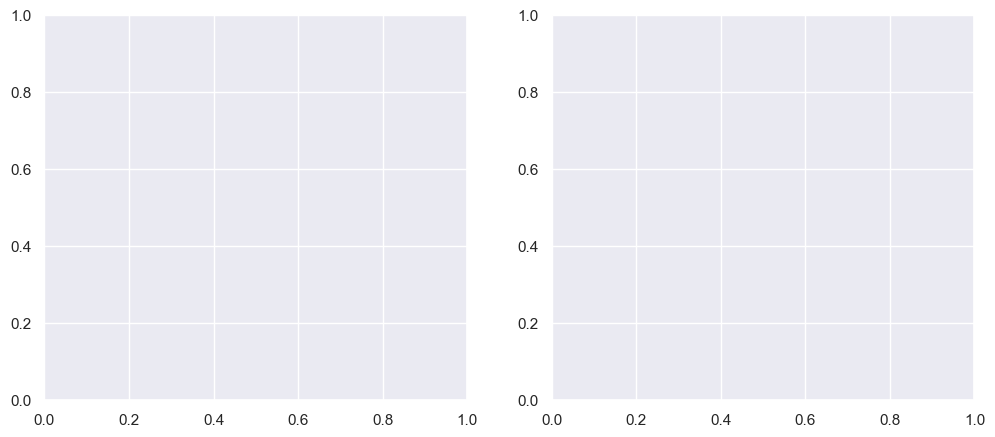

In [131]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

In [86]:
# Protyping metrics

test_session_df = old_bonsai_df.copy()

# Testing filtering
version = '2.3'
version_filt_test_session_df = test_session_df[test_session_df['curriculum_version'] == version]
curriculum_name = 'Uncoupled Baiting'
curriculum_filt_test_session_df = test_session_df[test_session_df['curriculum_name'] == curriculum_name]


# Prototype metric 1: 1 / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_1'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials']) != 0,
    (1/ (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 2: finished rate / (early lick rate + double dipping rate)
curriculum_filt_test_session_df['prototype_metric_2'] = np.where(
    (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['finished_rate']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['early_lick_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'])),
    np.inf
)

# Prototype metric 3: finished rate / (double dipping rate + reaction time*0.0001)
curriculum_filt_test_session_df['prototype_metric_3'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    ((curriculum_filt_test_session_df['finished_rate'] / curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + (curriculum_filt_test_session_df['reaction_time_mean']*0.0001))),
    np.inf
)

# Prototype metric 4: finished rate / (finished rate + double dipping rate + reaction time)
curriculum_filt_test_session_df['prototype_metric_4'] = np.where(
    (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean']) != 0,
    (curriculum_filt_test_session_df['finished_rate'] / (curriculum_filt_test_session_df['finished_rate'] + curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] + curriculum_filt_test_session_df['reaction_time_mean'])),
    np.inf
)

# Prototype metric 5: finished rate * lick consistency / (1 + early_lick_rate + double_dipping_rate)
curriculum_filt_test_session_df['prototype_metric_5'] = (
    (2 * curriculum_filt_test_session_df['finished_rate'] * curriculum_filt_test_session_df['reward_rate'] * 
     curriculum_filt_test_session_df['lick_consistency_mean_finished_trials']) /
    (1 + curriculum_filt_test_session_df['early_lick_rate'] + 
     2 * curriculum_filt_test_session_df['double_dipping_rate_finished_trials'] +
     curriculum_filt_test_session_df['invalid_lick_ratio'])
)

# Preprocessing 
#test_session_df = bu.filter_by_group_size(test_session_df, group_col='subject_id', max_rows=30)
curriculum_filt_test_session_df = bu.clean_dataframe(curriculum_filt_test_session_df, threshold=0.5, verbose=True)
curriculum_filt_test_session_df = bu.add_session_column(curriculum_filt_test_session_df)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']
curriculum_filt_test_session_df['current_stage_actual'] = pd.Categorical(curriculum_filt_test_session_df['current_stage_actual'], categories=stage_order)

Removed 0 rows with more than 50.0% NaN values

Remaining NaN counts per column:
old_bpod_session                    1406
laser_1_calibration_power           1406
experiment_description              1406
laser_2_target_areas                1406
laser_1_target_areas                1406
laser_2_calibration_power           1406
notes                               1122
results                              500
results_location                     500
task_type                            274
co_data_asset_ID                     274
session_time                         274
session_name                         274
creation_time                        274
virus                                274
fiber_probes                         274
subject_genotype                     274
location                             274
injections                           274
NM_recorded                          274
lickspout_movement_range_y           150
lickspout_movement_range_z           150
lickspout_median_

In [87]:
bu.analyze_column_distribution(curriculum_filt_test_session_df, 'curriculum_name')

{'value_counts': curriculum_name
 Uncoupled Baiting    1406
 Name: count, dtype: int64,
 'percentages': curriculum_name
 Uncoupled Baiting    100.0
 Name: proportion, dtype: float64,
 'total_count': 1406,
 'unique_values': 1,
 'most_common': ('Uncoupled Baiting', 1406),
 'least_common': ('Uncoupled Baiting', 1406)}

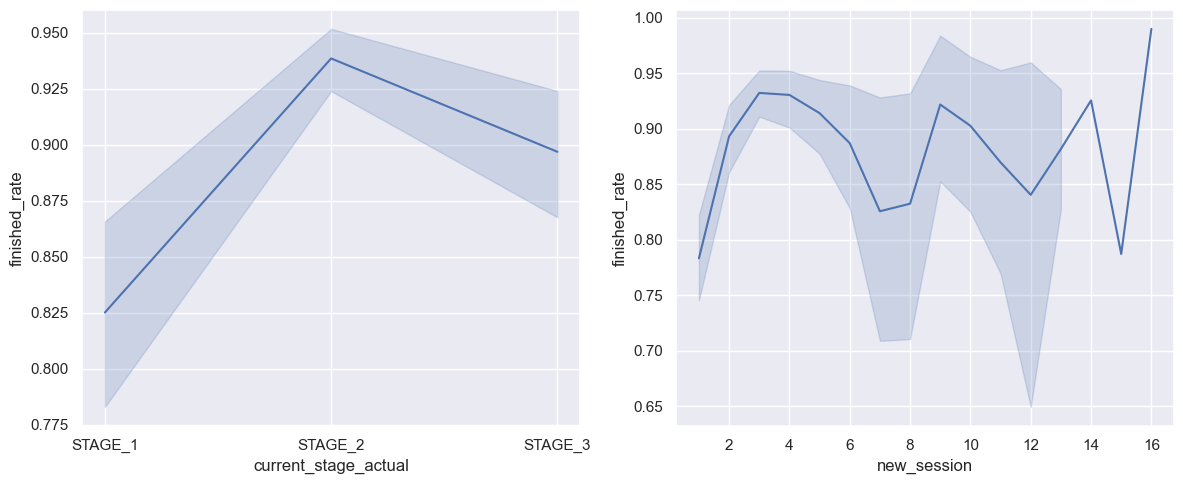

In [138]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='finished_rate', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='finished_rate', 
             ax=ax2)


plt.tight_layout()

ValueError: Could not interpret value `prototype_metric_1` for `y`. An entry with this name does not appear in `data`.

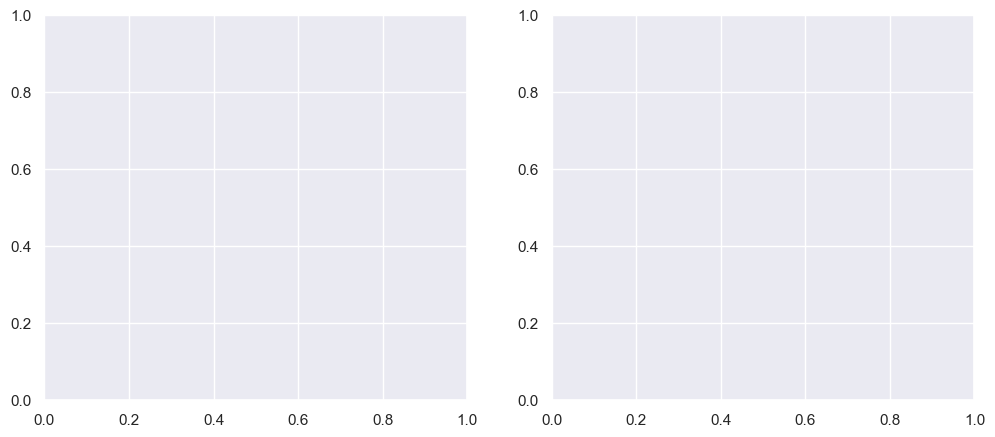

In [139]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_1', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_1', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

ValueError: Could not interpret value `prototype_metric_2` for `y`. An entry with this name does not appear in `data`.

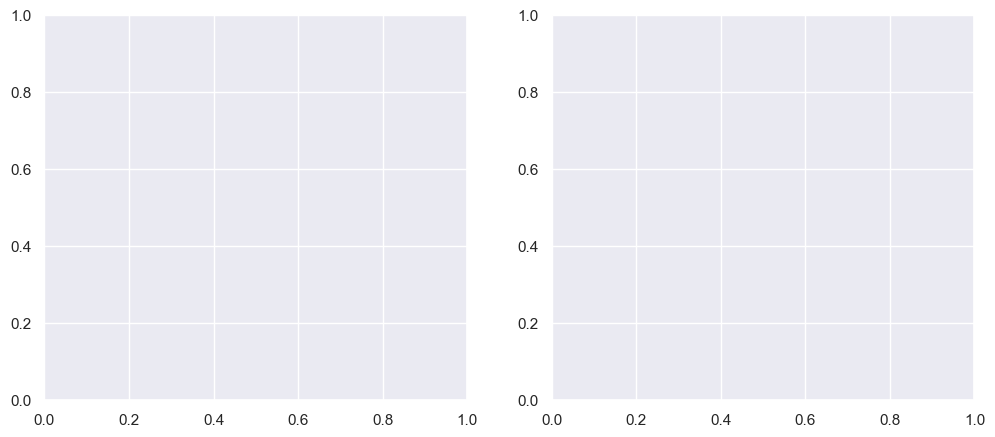

In [140]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_2', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_2', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

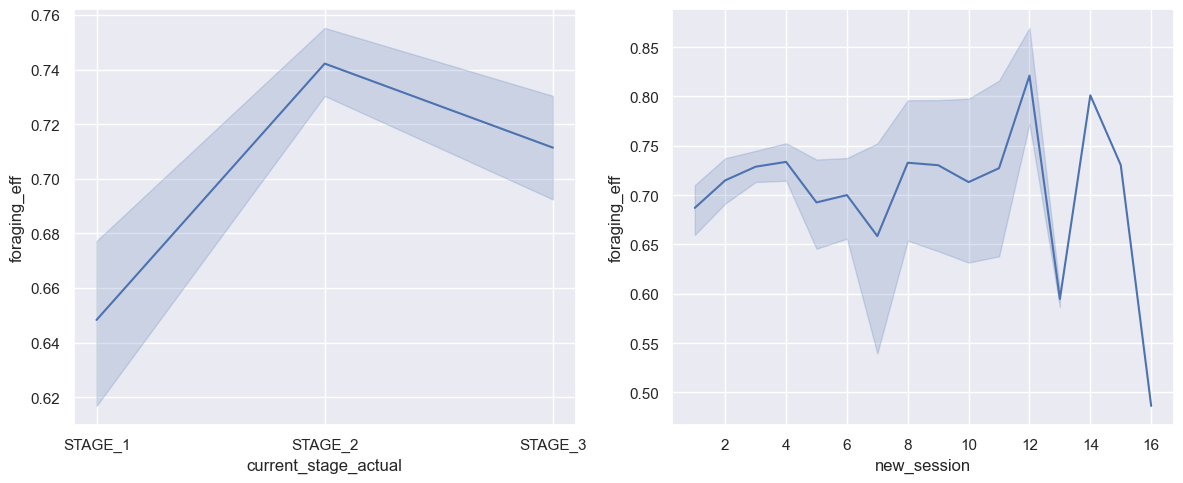

In [141]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='foraging_eff', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='foraging_eff', 
              ax=ax2)


plt.tight_layout()

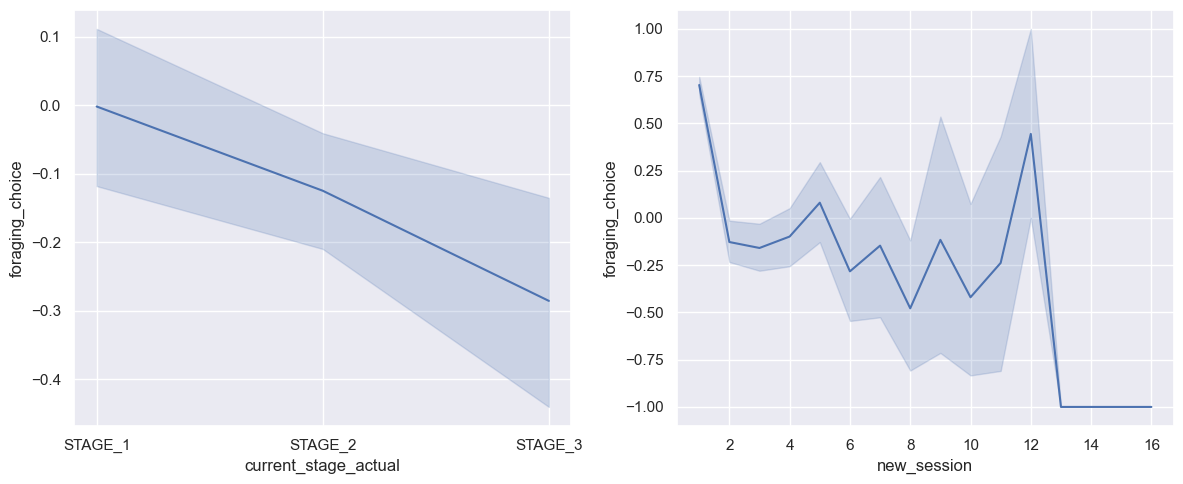

In [149]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='foraging_choice', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='foraging_choice', 
              ax=ax2)


plt.tight_layout()

ValueError: Could not interpret value `prototype_metric_4` for `y`. An entry with this name does not appear in `data`.

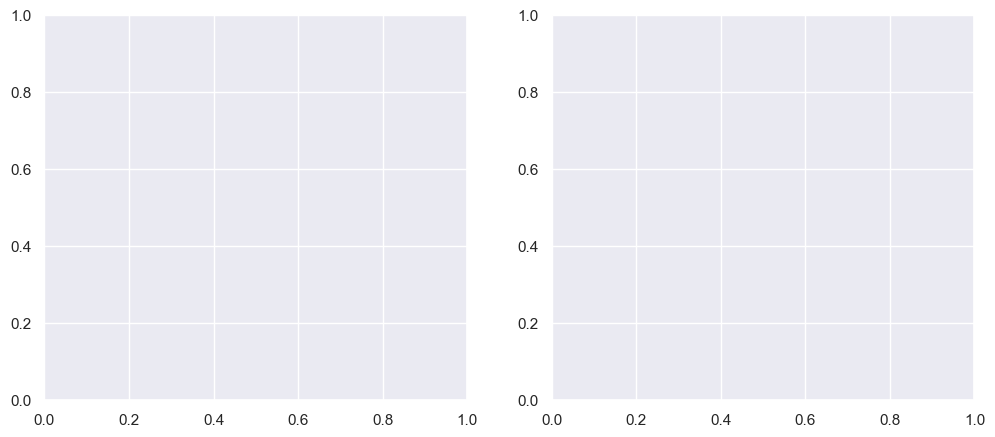

In [142]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_4', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_4', 
             hue='curriculum_name', ax=ax2)


plt.tight_layout()

ValueError: Could not interpret value `prototype_metric_5` for `y`. An entry with this name does not appear in `data`.

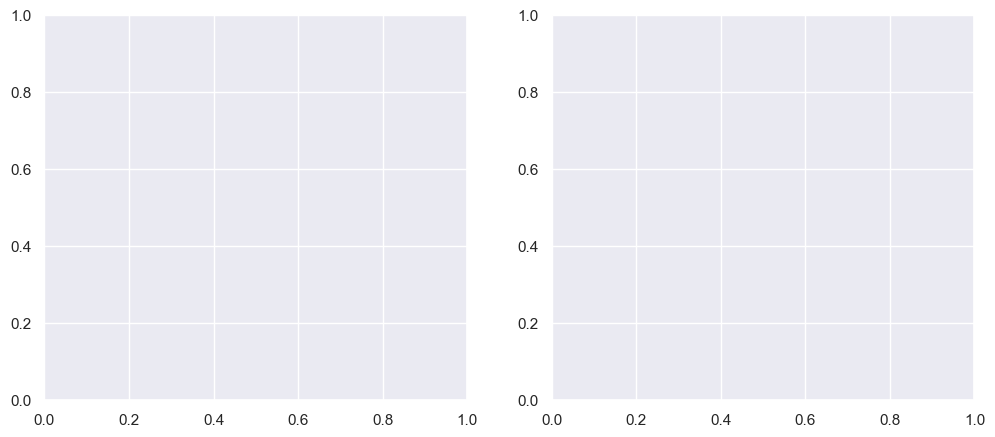

In [143]:
# Plot both metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot by stage
sns.lineplot(data=curriculum_filt_test_session_df, x='current_stage_actual', y='prototype_metric_5', hue='curriculum_name', ax=ax1)

# Plot by session with curriculum
sns.lineplot(data=curriculum_filt_test_session_df, x='new_session', y='prototype_metric_5', 
             hue='curriculum_name', ax=ax2)

plt.tight_layout()

##### Metric Eval

In [144]:
# Array utils
array_df = curriculum_filt_test_session_df.copy()

# Create custom group limits
stage_counts = array_df.groupby(['subject_id', 'current_stage_actual']).size().unstack(fill_value=0)
stage_lims = {stage: int(stage_counts[stage].quantile(0.95)) for stage in stage_counts.columns}

array_df = bu.filter_by_group_size(array_df, 
                                   group_col='subject_id', 
                                   category_col='current_stage_actual', 
                                   category_limits=stage_lims)


# Generate prototype metric arrays

# Prototype metric 5
prot_type_five = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_5', 
                          task_col=None)

# Prototype metric 4
prot_type_four = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='prototype_metric_4', 
                          task_col=None)

# Generate foraging eff array for comparison
foraging_eff_array = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric='foraging_eff', 
                          task_col=None)

# Univariate arrays
uni_arrays = au.create_arrays(array_df, 
                          stage_col='current_stage_actual', 
                          subject_col='subject_id', 
                          metric= 'finished_rate', 
                          task_col=None)



# Summary statistics
au.summary_statistics(prot_type_four)

No data found for nan


KeyError: 'prototype_metric_5'

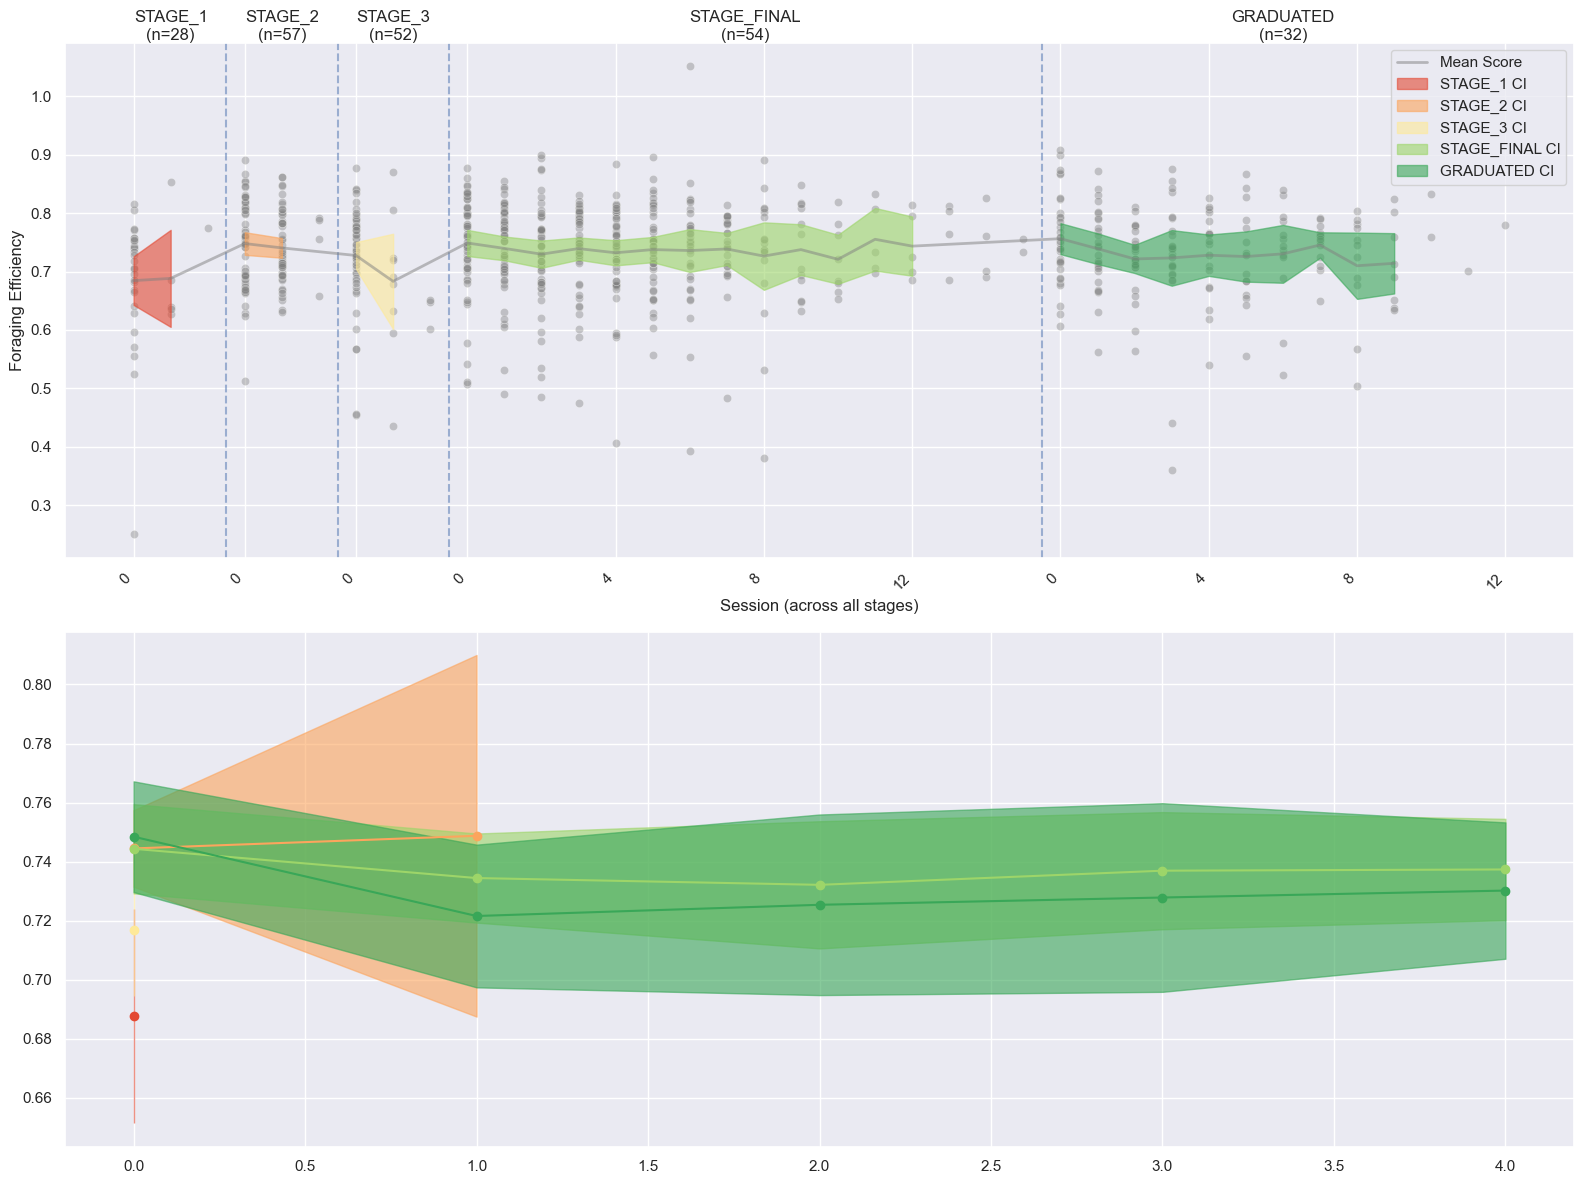


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.733  0.080  0.006  0.361  0.909        32
STAGE_1       34  0.688  0.108  0.019  0.250  0.853        28
STAGE_2      111  0.745  0.068  0.006  0.512  0.892        57
STAGE_3       64  0.717  0.091  0.011  0.436  0.877        52
STAGE_FINAL  417  0.738  0.080  0.004  0.380  1.052        54

Outlier Analysis:

STAGE_1:
Number of outliers: 1
Outlier values: [0.25]
Percentage: 2.9%

STAGE_2:
Number of outliers: 1
Outlier values: [0.51220963]
Percentage: 0.9%

STAGE_3:
Number of outliers: 1
Outlier values: [0.4355183]
Percentage: 1.6%

STAGE_FINAL:
Number of outliers: 8
Outlier values: [0.49091372 0.48594306 0.47522013 0.40638287 1.05190224 0.3928735
 0.48324504 0.38007795]
Percentage: 1.9%

GRADUATED:
Number of outliers: 2
Outlier values: [0.36083722 0.44089602]
Percentage: 1.1%

Performance Summary:

STAGE_1:
Session

In [145]:
au.ci_plot_metric(foraging_eff_array, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True)

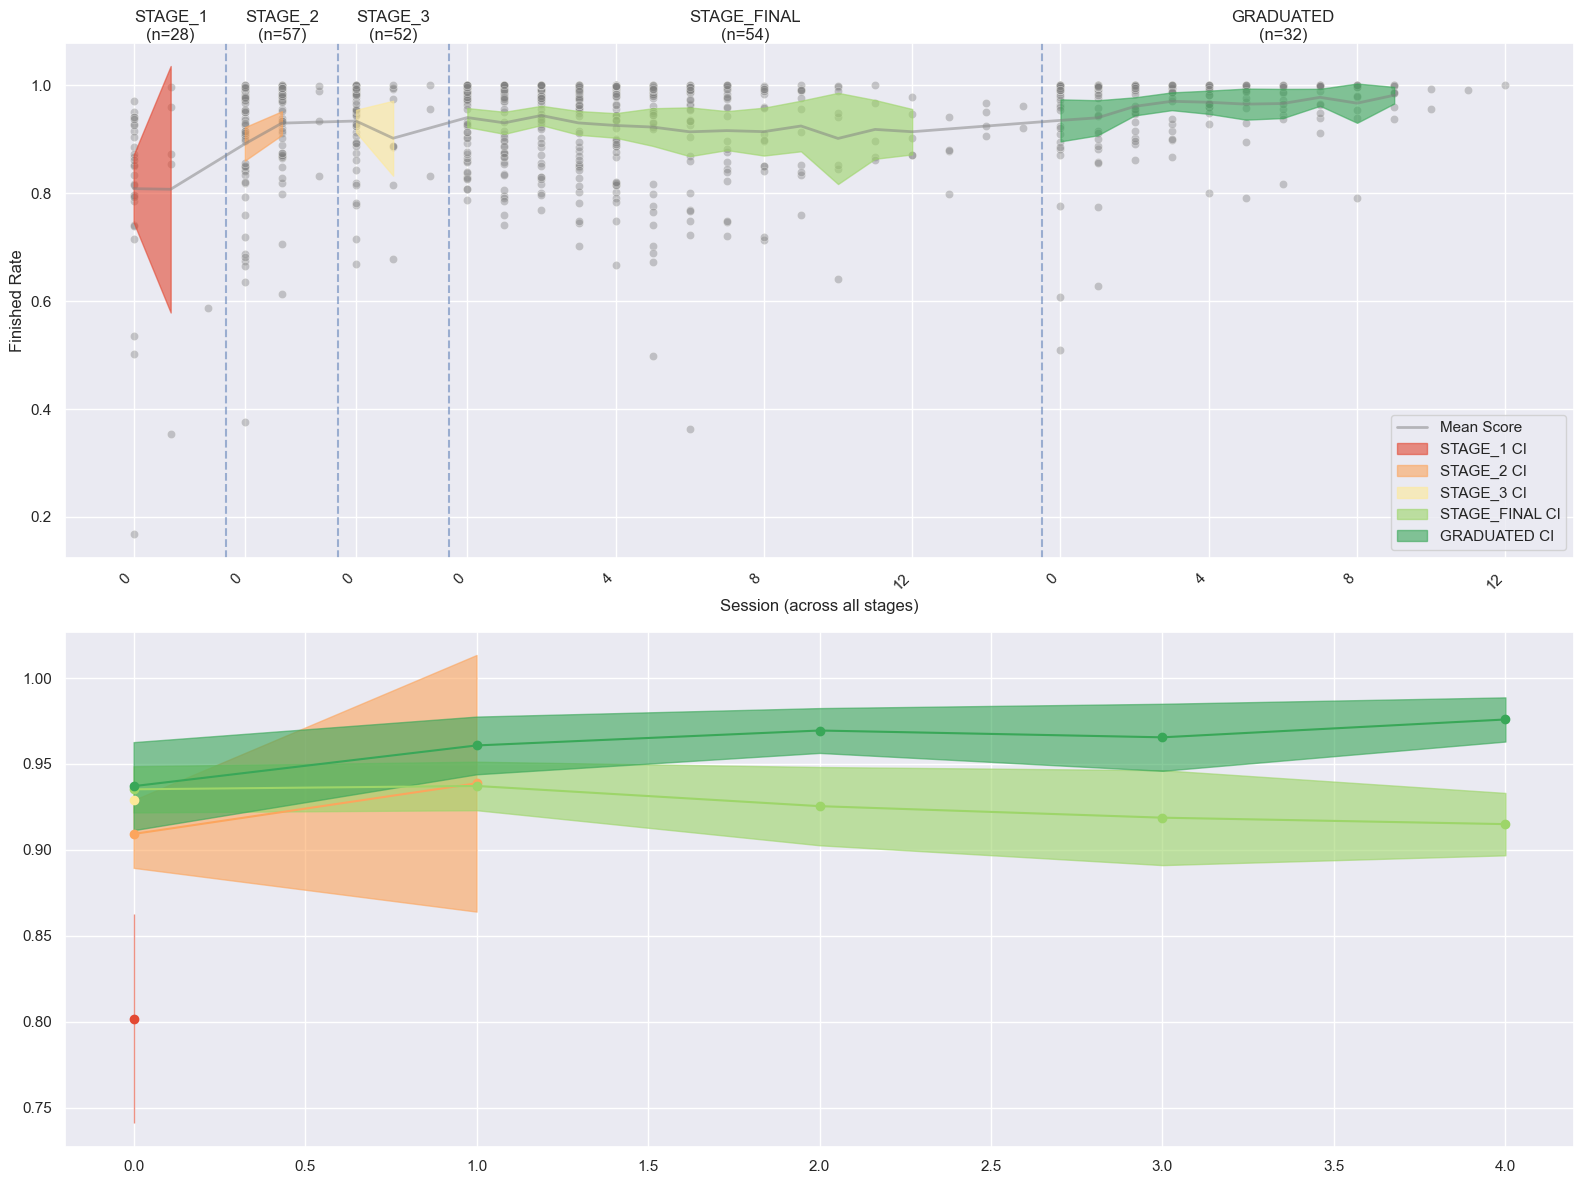


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.959  0.068  0.005  0.509  1.000        32
STAGE_1       34  0.802  0.181  0.031  0.168  0.996        28
STAGE_2      111  0.910  0.103  0.010  0.376  1.000        57
STAGE_3       64  0.929  0.081  0.010  0.668  1.000        52
STAGE_FINAL  417  0.928  0.087  0.004  0.363  1.000        54

Outlier Analysis:

STAGE_1:
Number of outliers: 1
Outlier values: [0.16759777]
Percentage: 2.9%

STAGE_2:
Number of outliers: 1
Outlier values: [0.3757764]
Percentage: 0.9%

STAGE_3:
Number of outliers: 2
Outlier values: [0.66794626 0.67741935]
Percentage: 3.1%

STAGE_FINAL:
Number of outliers: 4
Outlier values: [0.66666667 0.49880096 0.36326531 0.64009112]
Percentage: 1.0%

GRADUATED:
Number of outliers: 3
Outlier values: [0.50900901 0.60833333 0.62772277]
Percentage: 1.6%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM:

In [146]:
au.ci_plot_metric(uni_arrays, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Finished Rate')

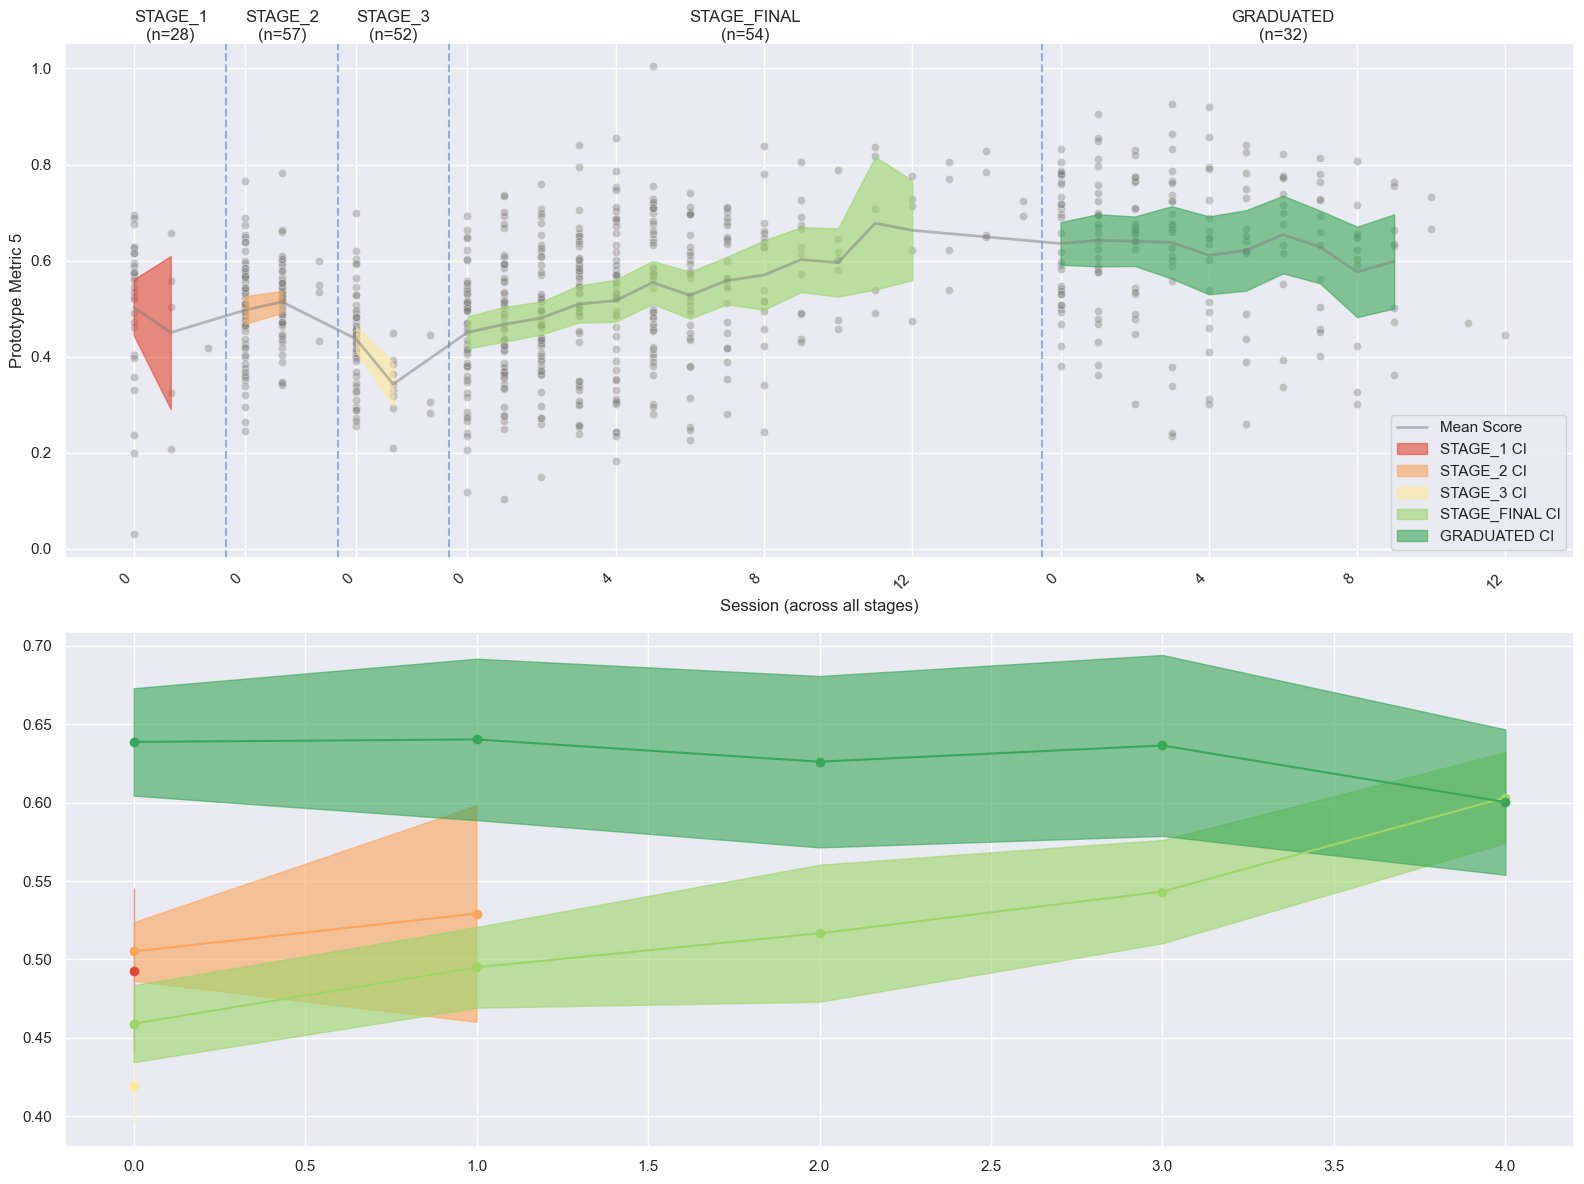


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.629  0.148  0.011  0.235  0.926        32
STAGE_1       34  0.493  0.157  0.027  0.030  0.695        28
STAGE_2      111  0.506  0.098  0.009  0.246  0.782        57
STAGE_3       64  0.419  0.099  0.012  0.210  0.700        52
STAGE_FINAL  417  0.518  0.146  0.007  0.104  1.005        54

Outlier Analysis:

STAGE_FINAL:
Number of outliers: 1
Outlier values: [1.00496414]
Percentage: 0.2%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.477 ± 0.022
Subjects: 28
Sample size range: 1-28
Sessions below threshold: 1

STAGE_2:
Sessions: 3
Mean ± SEM: 0.506 ± 0.007
Subjects: 57
Sample size range: 4-57
Sessions below threshold: 1

STAGE_3:
Sessions: 3
Mean ± SEM: 0.390 ± 0.038
Subjects: 52
Sample size range: 3-52
Sessions below threshold: 1

STAGE_FINAL:
Sessions: 16
Mean ± SEM: 0.552 ± 0.018
Subjects: 54
Sample 

In [147]:
au.ci_plot_metric(prot_type_five, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 5')

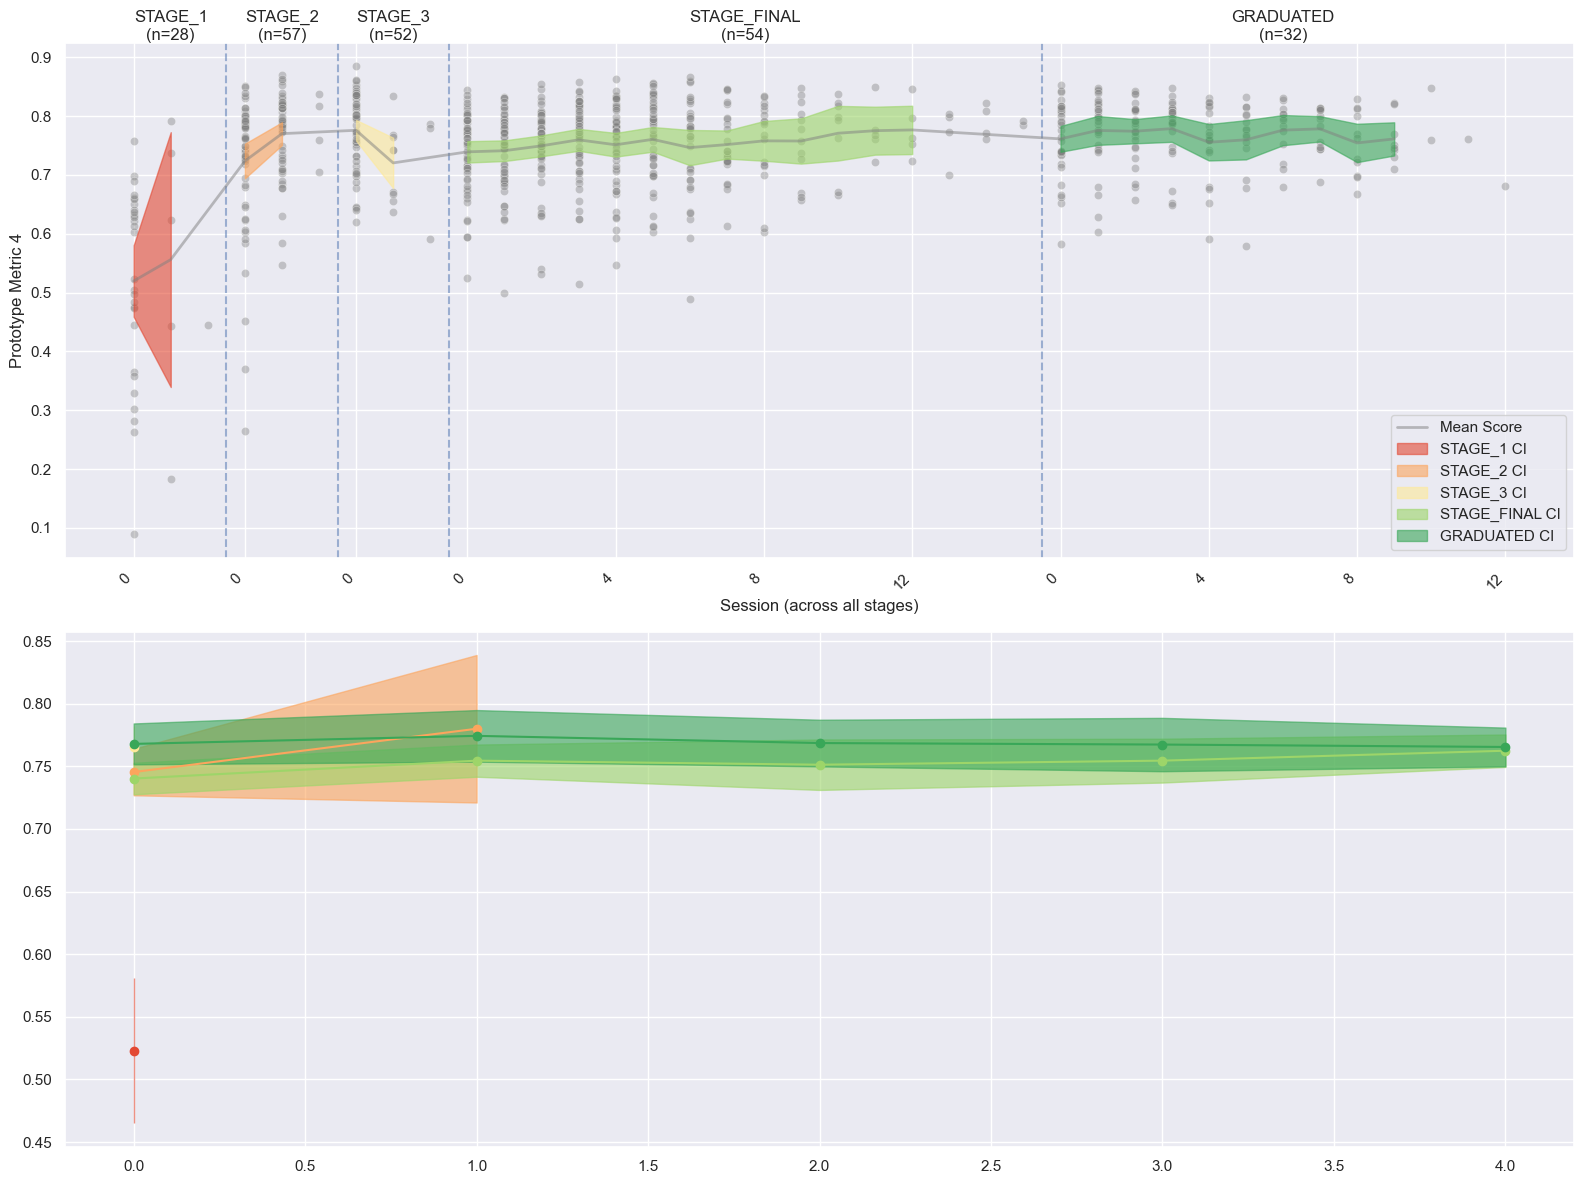


Detailed Statistics by Stage:
               N   Mean    Std    SEM    Min    Max  Subjects
Stage                                                        
GRADUATED    188  0.768  0.057  0.004  0.580  0.852        32
STAGE_1       34  0.523  0.172  0.030  0.089  0.792        28
STAGE_2      111  0.747  0.097  0.009  0.265  0.870        57
STAGE_3       64  0.765  0.069  0.009  0.592  0.885        52
STAGE_FINAL  417  0.752  0.068  0.003  0.490  0.866        54

Outlier Analysis:

STAGE_2:
Number of outliers: 3
Outlier values: [0.45218769 0.37061277 0.26508537]
Percentage: 2.7%

STAGE_FINAL:
Number of outliers: 6
Outlier values: [0.52501939 0.49856653 0.54053263 0.53117533 0.5144288  0.4898607 ]
Percentage: 1.4%

GRADUATED:
Number of outliers: 3
Outlier values: [0.58303243 0.59131232 0.57964834]
Percentage: 1.6%

Performance Summary:

STAGE_1:
Sessions: 3
Mean ± SEM: 0.538 ± 0.015
Subjects: 28
Sample size range: 1-28
Sessions below threshold: 1

STAGE_2:
Sessions: 3
Mean ± SEM: 0.747 ± 

In [148]:
au.ci_plot_metric(prot_type_four, 
           verbose=True,
           min_sample_threshold=5,
           ci_level=0.95,
           zscore_threshold=3,
           normalize_stages=True,
           ylabel='Prototype Metric 4')